## Etapa 1: Importação das bibliotecas

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.metrics import mean_absolute_error
torch.__version__

'1.13.1+cu116'

In [ ]:
torch.manual_seed(123)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Etapa 2: Base de dados

In [ ]:
base = pd.read_csv('/content/drive/MyDrive/Deep Learing de A à Z com PyTorch/Bases/petr4_treinamento.csv')
base = base.dropna()
base_train = base.iloc[:, 1:3].values

In [ ]:
base.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [ ]:
base_train

array([[19.99    , 20.209999],
       [19.809999, 20.4     ],
       [20.33    , 20.620001],
       ...,
       [15.99    , 16.139999],
       [16.1     , 16.129999],
       [16.1     , 16.1     ]])

In [ ]:
normalizador = MinMaxScaler(feature_range = (0, 1))
base_train_norm = normalizador.fit_transform(base_train)

In [ ]:
X = []
y = []
for i in range(90, 1242):
    X.append(base_train_norm[i-90:i, 0])
    y.append(base_train_norm[i, 0:2]) # `y` terá duas colunas
X, y = np.array(X), np.array(y)

In [ ]:
X[0]

array([0.76501938, 0.7562984 , 0.78149225, 0.78875969, 0.77083338,
       0.74806197, 0.75436047, 0.75823643, 0.76598837, 0.76598837,
       0.76017437, 0.75872098, 0.75581391, 0.74467054, 0.7374031 ,
       0.7374031 , 0.73498067, 0.75242248, 0.73401163, 0.71656977,
       0.68120155, 0.67538755, 0.67635659, 0.63372098, 0.66521318,
       0.65649225, 0.64680228, 0.66618222, 0.65843028, 0.64970935,
       0.65116274, 0.66424419, 0.67344961, 0.64292631, 0.64486434,
       0.62257747, 0.60949617, 0.60998067, 0.60852713, 0.59593023,
       0.61143411, 0.60222863, 0.64922481, 0.68362398, 0.70687989,
       0.68265509, 0.70978682, 0.70784879, 0.71608527, 0.73643411,
       0.7122093 , 0.7122093 , 0.7194767 , 0.70348832, 0.69525189,
       0.70397287, 0.70397287, 0.69767442, 0.68168605, 0.68168605,
       0.65310078, 0.66618222, 0.64825581, 0.66182175, 0.64341085,
       0.67877902, 0.69137592, 0.66569772, 0.65406982, 0.64292631,
       0.64147292, 0.63565891, 0.67587209, 0.68653106, 0.70300

In [ ]:
y[0]

array([0.76114341, 0.76490543])

In [ ]:
X = torch.tensor(X, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

In [ ]:
dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)

## Etapa 3: Construção da rede neural recorrente

In [ ]:
class regressor_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lstm1 = nn.LSTM(input_size = 1, hidden_size = 100, batch_first = True)
        self.lstm2 = nn.LSTM(100, 50, batch_first = True)
        self.lstm3 = nn.LSTM(50, 50, dropout = 0.3, num_layers = 2, batch_first = True)
        self.dropout = nn.Dropout(p = 0.3)
        self.linear = nn.Linear(in_features = 50, out_features = 2)
        
    def forward(self, X):
        X = X.unsqueeze(2)
        X, _ = self.lstm1(X)
        X = self.dropout(X)
        X, _ = self.lstm2(X)
        X = self.dropout(X)
        X, _ = self.lstm3(X)
        
        X = X[:, -1, :]
        X = self.dropout(X)
        X = self.linear(X)
       
        return X

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
regressor = regressor_LSTM()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(regressor.parameters(), lr = 1e-3, alpha = 0.9)
regressor.to(device)

regressor_LSTM(
  (lstm1): LSTM(1, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (lstm3): LSTM(50, 50, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

## Etapa 4: Treinamento do modelo

In [ ]:
for epoch in range(100):
    running_loss = 0.
    running_mae = 0.
          
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = regressor(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
    
        running_loss += loss.item()
        
        mae = mean_absolute_error(labels.detach().cpu().numpy().flatten(), 
                                  outputs.detach().cpu().numpy().flatten())
        running_mae += mae
        
        # Imprimindo os dados referentes a esse loop
        print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: custo {:03.5f} - MAE {:03.5f}'.format(epoch + 1, i + 1, len(loader), loss, mae), end = '\r')
    
    # Imprimindo os dados referentes a essa época
    running_loss /= len(loader)
    running_mae /= len(loader)
    print('ÉPOCA {:3d} FINALIZADA: custo {:03.6f} - MAE {:03.6f}     '.format(epoch + 1, running_loss, running_mae))


ÉPOCA   1 FINALIZADA: custo 0.061615 - MAE 0.194932     
ÉPOCA   2 FINALIZADA: custo 0.030491 - MAE 0.139691     
ÉPOCA   3 FINALIZADA: custo 0.020149 - MAE 0.113854     
ÉPOCA   4 FINALIZADA: custo 0.015799 - MAE 0.099659     
ÉPOCA   5 FINALIZADA: custo 0.013676 - MAE 0.090054     
ÉPOCA   6 FINALIZADA: custo 0.011103 - MAE 0.082214     
ÉPOCA   7 FINALIZADA: custo 0.010327 - MAE 0.078298     
ÉPOCA   8 FINALIZADA: custo 0.009395 - MAE 0.075753     
ÉPOCA   9 FINALIZADA: custo 0.008561 - MAE 0.071927     
ÉPOCA  10 FINALIZADA: custo 0.007425 - MAE 0.066929     
ÉPOCA  11 FINALIZADA: custo 0.007567 - MAE 0.067030     
ÉPOCA  12 FINALIZADA: custo 0.006788 - MAE 0.063605     
ÉPOCA  13 FINALIZADA: custo 0.006883 - MAE 0.064191     
ÉPOCA  14 FINALIZADA: custo 0.005814 - MAE 0.058622     
ÉPOCA  15 FINALIZADA: custo 0.005662 - MAE 0.058444     
ÉPOCA  16 FINALIZADA: custo 0.005975 - MAE 0.058660     
ÉPOCA  17 FINALIZADA: custo 0.005149 - MAE 0.055734     
ÉPOCA  18 FINALIZADA: custo 0.0

## Etapa 5: Processamento da base de teste

In [ ]:
base_teste = pd.read_csv('/content/drive/MyDrive/Deep Learing de A à Z com PyTorch/Bases/petr4_teste.csv')
base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1, 1)

In [ ]:
normalizador = MinMaxScaler().fit(base_train[:, 0:1])
entradas = normalizador.transform(entradas)

In [ ]:
X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0])
X_teste = np.array(X_teste)

In [ ]:
X_teste = torch.tensor(X_teste, device = device, dtype = torch.float32)

## Etapa 6: Previsões

In [ ]:
regressor.eval()
previsoes = regressor(X_teste)
previsoes = previsoes.detach().cpu().numpy()
previsoes = normalizador.inverse_transform(previsoes)

In [ ]:
previsoes

array([[16.161297, 16.379658],
       [16.227999, 16.447514],
       [16.488827, 16.712276],
       [16.803686, 17.032284],
       [16.819077, 17.04876 ],
       [16.82348 , 17.053534],
       [17.05826 , 17.291882],
       [17.052397, 17.286528],
       [16.991768, 17.225172],
       [17.101688, 17.336636],
       [17.367876, 17.60699 ],
       [17.464722, 17.705967],
       [17.91879 , 18.16726 ],
       [18.392485, 18.64947 ],
       [18.458168, 18.717863],
       [18.401596, 18.661186],
       [18.494263, 18.755455],
       [18.543459, 18.805788],
       [19.267443, 19.541246],
       [19.673681, 19.956171],
       [19.76584 , 20.051771],
       [19.84591 , 20.134157]], dtype=float32)

In [ ]:
previsoes.mean(axis = 0)

array([17.778305, 18.0258  ], dtype=float32)

In [ ]:
base_teste['Open'].mean()

17.87454563636364

In [ ]:
base_teste['High'].mean()

18.148181636363635

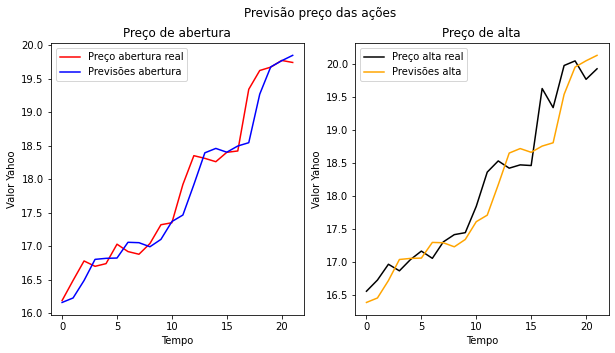

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Previsão preço das ações')

ax[0].plot(base_teste['Open'], color = 'red', label = 'Preço abertura real')
ax[0].plot(previsoes[:, 0], color = 'blue', label = 'Previsões abertura')
ax[0].set_title('Preço de abertura')
ax[0].set_xlabel('Tempo')
ax[0].set_ylabel('Valor Yahoo')
ax[0].legend()

ax[1].plot(base_teste['High'], color = 'black', label = 'Preço alta real')
ax[1].plot(previsoes[:, 1], color = 'orange', label = 'Previsões alta')
ax[1].set_title('Preço de alta')
ax[1].set_xlabel('Tempo')
ax[1].set_ylabel('Valor Yahoo')
ax[1].legend()